## Simulated Annealing Classification

This example demonstrates **Simulated Annealing (SA)** applied to a binary classification task using the `Perch` builder API.   
A simple MLP classifier is trained on a synthetic dataset, with SA controlling parameter updates via a temperature schedule and stochastic acceptance.

The builder handles model construction, data splitting, and optimizer configuration, while training progress is visualized using the built-in loss and accuracy plots.

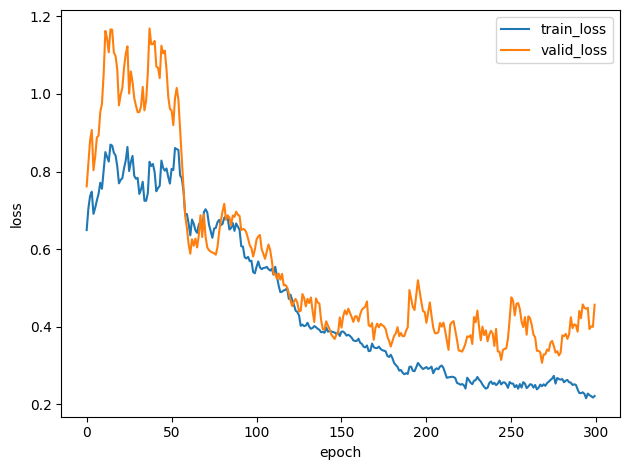

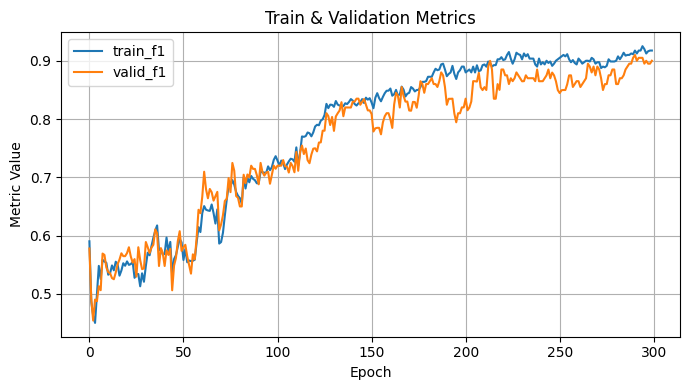

In [4]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.utils import plot_losses, plot_metrics
from pyperch.core.metrics import F1

# -------------------------------------------------------------------
# 1. Reproducibility
# -------------------------------------------------------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# -------------------------------------------------------------------
# 2. Dataset
# -------------------------------------------------------------------
X, y = make_classification(
    n_samples=1000,
    n_features=12,
    n_informative=10,
    n_classes=2,
    random_state=seed,
)

X = X.astype(np.float32)
y = y.astype(np.int64)

# -------------------------------------------------------------------
# 3. Builder: model + data + optimizer
# -------------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=12,
        hidden=[32],
        output_dim=2,
        activation="relu",
        loss_fn=nn.CrossEntropyLoss(),
    )
    .optimizer(
        "sa",
        t=2.0,
        t_min=0.001,
        cooling=0.995,
        step_size=0.05,
    )
    .metrics(F1())
    .data(
        X,
        y,
        batch_size=64,
        valid_split=0.2,
        stratify=True,
        normalize=None,
    )
)

# -------------------------------------------------------------------
# 4. Train
# -------------------------------------------------------------------
trainer, history = perch.train(
    max_epochs=300,
    seed=seed,
    optimizer_mode="per_batch",
)

# -------------------------------------------------------------------
# 5. Plots
# -------------------------------------------------------------------
plot_losses(history)
plt.show()

plot_metrics(history)
plt.show()

## Simulated Annealing Regression

This example demonstrates SA applied to a regression task using the `Perch` builder API.  
A simple MLP regressor is trained on a synthetic dataset, with SA optimizing the model’s parameters using a temperature schedule and stochastic acceptance.

The builder facilitates model creation, data handling, and optimizer setup, while training progress and performance are visualized through the loss and $R^2$ plots.

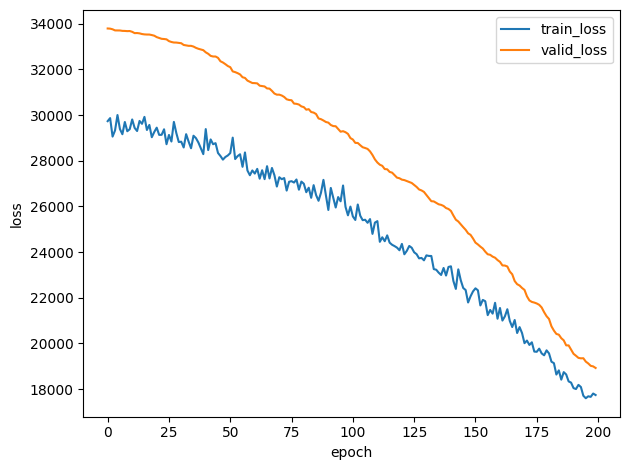

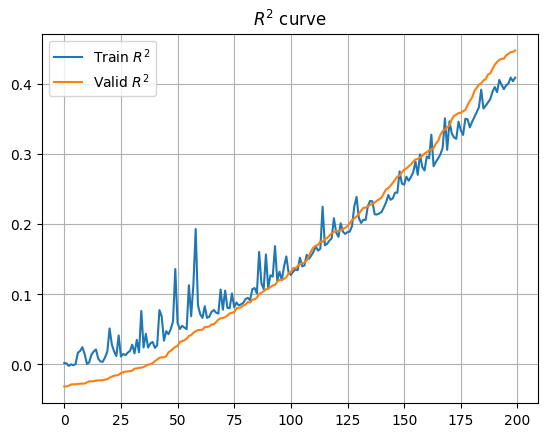

In [3]:
# REGRESSION

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.utils import plot_losses
from pyperch.core.metrics import MSE, R2

# -------------------------------------------------------------------
# 1. Reproducibility
# -------------------------------------------------------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# -------------------------------------------------------------------
# 2. Regression dataset
# -------------------------------------------------------------------
X, y = make_regression(
    n_samples=1000,
    n_features=12,
    noise=0.2,
    random_state=seed,
)

X = X.astype(np.float32)
y = y.reshape(-1, 1).astype(np.float32)

# -------------------------------------------------------------------
# 3. Builder: model + optimizer + data
# -------------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=12,
        hidden=[32],
        output_dim=1,
        activation="leaky_relu",
        loss_fn=nn.MSELoss(),
    )
    .optimizer(
        "sa",
        t=2.0,
        t_min=0.001,
        cooling=0.995,
        step_size=0.1,      
    )
    .metrics(MSE(), R2())
    .data(
        X,
        y,
        batch_size=64,
        valid_split=0.2,
        stratify=False,
        normalize=None,
    )
)

# -------------------------------------------------------------------
# 4. Train
# -------------------------------------------------------------------
trainer, history = perch.train(
    max_epochs=200,
    seed=seed,
    optimizer_mode="per_batch",
)

# -------------------------------------------------------------------
# 5. Plots
# -------------------------------------------------------------------
plot_losses(history)
plt.show()

# R2 plot 
epochs = history["epoch"]
train_r2 = history["train_metrics"].get("r2", [])
valid_r2 = history["valid_metrics"].get("r2", [])

plt.figure()
plt.plot(epochs, train_r2, label="Train $R^2$")
plt.plot(epochs, valid_r2, label="Valid $R^2$")
plt.legend()
plt.grid()
plt.title("$R^2$ curve")
plt.show()
